In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten, Dense, Dropout

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam


In [2]:
#loading data
train_data_path = '/kaggle/input/dogs-cats-images/dataset/training_set/'
test_data_path = '/kaggle/input/dogs-cats-images/dataset/test_set'

# Data augmentation

In [3]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255   #normalize pixel values within the range of [0, 1] by dividing each pixel by 255.
    )
train = train_generator.flow_from_directory(
        directory=train_data_path, 
        batch_size=32, 
        target_size=(224,224)
    ) 


Found 8000 images belonging to 2 classes.


In [4]:

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )
test = test_generator.flow_from_directory(
        directory=test_data_path, 
        batch_size=32, 
        target_size=(224,224)
    )      


Found 2000 images belonging to 2 classes.


In [5]:
imgs,y=next(train) #storing all images in train in 'imgs' and y refer to label

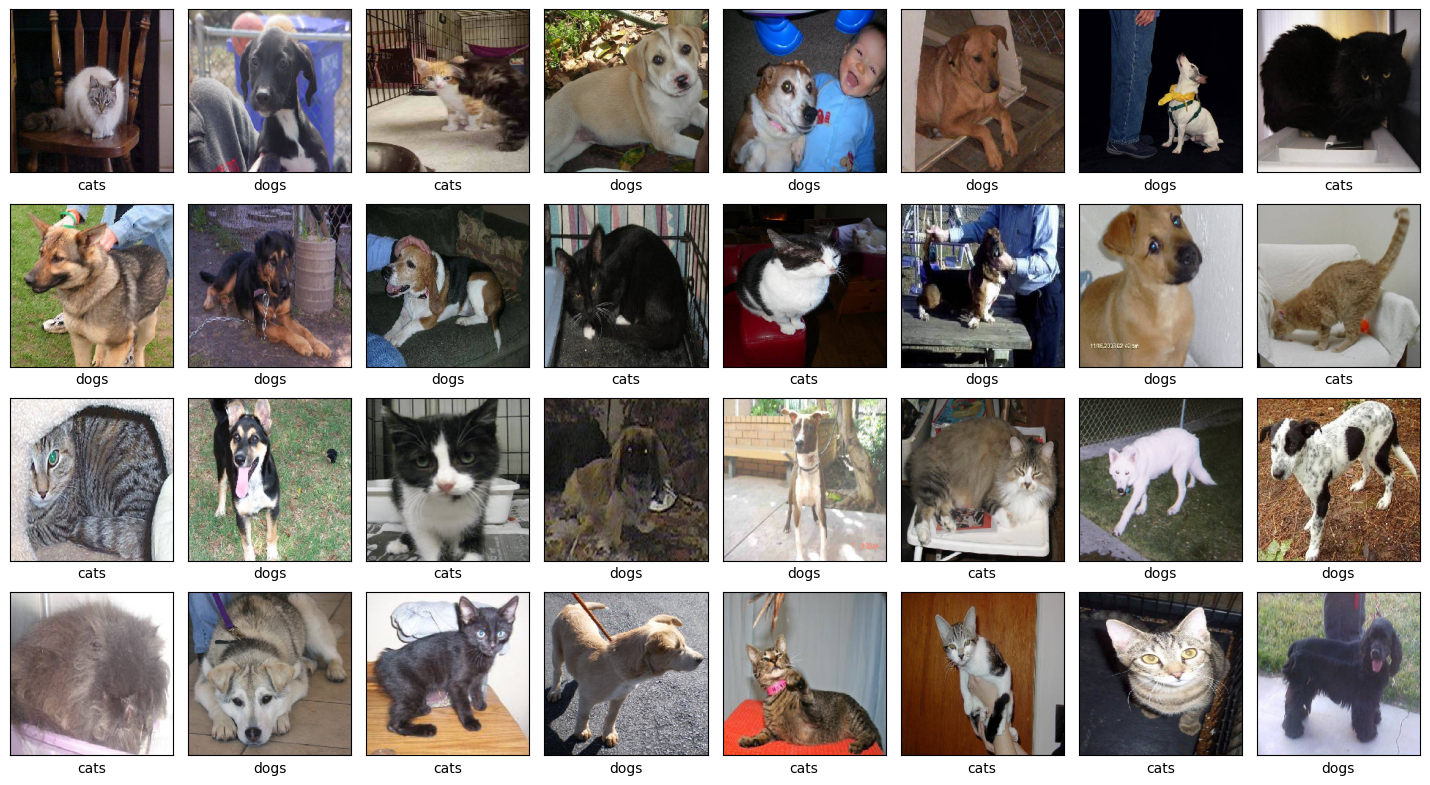

In [6]:
szx = 8
szy = 4
class_names = ['cats','dogs']
fig, axs = plt.subplots( szy,szx, figsize=[szx*1.8,szy*2] )
axs = axs.flatten()
for i, ax in enumerate(axs):            
    ax.imshow(imgs[i])
    ax.set_xticks( [] )
    ax.set_yticks( [] )
    ax.grid( False )
    ax.set_xlabel( class_names[ np.argmax(y[i],axis=0) ] )
   
plt.tight_layout()
    


# VGG16

In [7]:
vgg16_model=tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 2s 0us/step


In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
type(vgg16_model)

keras.src.engine.functional.Functional

In [10]:
model=keras.Sequential() #building empty model and then add in this all layer in vgg except last one
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [11]:
for layer in model.layers:
     layer.trainable=False  #freezing ==> غير قابله للتدريب يعنى اخدتها بالweights بتاعتها

In [12]:
model.add(keras.layers.Dense(2,activation='Softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
model.fit(train,
          validation_data=test,
          epochs=7,
          verbose=1,
          validation_steps=4
)

Epoch 1/7
250/250 [==============================] - 2115s 8s/step - loss: 0.4086 - accuracy: 0.8156 - val_loss: 0.2884 - val_accuracy: 0.8906
Epoch 2/7
250/250 [==============================] - 2124s 8s/step - loss: 0.2863 - accuracy: 0.8806 - val_loss: 0.2206 - val_accuracy: 0.9062
Epoch 3/7
250/250 [==============================] - 2115s 8s/step - loss: 0.2693 - accuracy: 0.8819 - val_loss: 0.2846 - val_accuracy: 0.8906
Epoch 4/7
250/250 [==============================] - 2105s 8s/step - loss: 0.2644 - accuracy: 0.8881 - val_loss: 0.2393 - val_accuracy: 0.8906
Epoch 5/7
250/250 [==============================] - 2107s 8s/step - loss: 0.2542 - accuracy: 0.8898 - val_loss: 0.2141 - val_accuracy: 0.9062
Epoch 6/7
250/250 [==============================] - 2120s 8s/step - loss: 0.2389 - accuracy: 0.8967 - val_loss: 0.2545 - val_accuracy: 0.9141
Epoch 7/7
250/250 [==============================] - 2103s 8s/step - loss: 0.2335 - accuracy: 0.9014 - val_loss: 0.2416 - val_accuracy: 0.8984

# Alexnet

In [16]:
def alexnet_model():
    # Start off the model
    model = Sequential()
    # 1st Convolution layer
    model.add(Conv2D(input_shape=(227,227,3), filters=96,kernel_size=(11,11),strides=(4,4),padding='valid'))
    model.add(Activation('relu'))
    # max pooling 1sst layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    
    # 2nd Convolution layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # max pooling for 2nd layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    
    # 3rd Convolution layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    # 4th Convolution layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    
    # 5th Convolution layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # max pooling for 5th layer
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    
    # dense layer
    model.add(Flatten())
    # 1st dense layer
    model.add(Dense(4096, input_shape=(6*6*256,)))
    model.add(Activation('relu'))
    # dropout to prevent overfitting
    model.add(Dropout(0.4))
    
    # 2nd dense layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # drop out to prevent overfitting
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    # 3rd dense layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    # output layer
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    # Uncomment line below to see architecture detail
    model.summary()
    
    return model


In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255   #normalize pixel values within the range of [0, 1] by dividing each pixel by 255.
    )
train = train_generator.flow_from_directory(
        directory=train_data_path, 
        batch_size=32, 
        target_size=(227,227)
    ) 

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )
test = test_generator.flow_from_directory(
        directory=test_data_path, 
        batch_size=32, 
        target_size=(227,227)
    )      


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
model = alexnet_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 23, 23, 256)      

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [20]:
history=model.fit(train,
          validation_data=test,
          epochs=15,
          verbose=1,
          validation_steps=4
)

Epoch 1/15
250/250 [==============================] - 392s 2s/step - loss: 1.0734 - accuracy: 0.5219 - val_loss: 0.6916 - val_accuracy: 0.5234
Epoch 2/15
250/250 [==============================] - 386s 2s/step - loss: 0.6971 - accuracy: 0.5592 - val_loss: 0.6675 - val_accuracy: 0.6250
Epoch 3/15
250/250 [==============================] - 386s 2s/step - loss: 0.6644 - accuracy: 0.5959 - val_loss: 0.6698 - val_accuracy: 0.5859
Epoch 4/15
250/250 [==============================] - 387s 2s/step - loss: 0.6442 - accuracy: 0.6294 - val_loss: 0.7443 - val_accuracy: 0.5625
Epoch 5/15
250/250 [==============================] - 387s 2s/step - loss: 0.6169 - accuracy: 0.6646 - val_loss: 0.6823 - val_accuracy: 0.6094
Epoch 6/15
250/250 [==============================] - 390s 2s/step - loss: 0.5738 - accuracy: 0.7020 - val_loss: 1.8294 - val_accuracy: 0.4844
Epoch 7/15
250/250 [==============================] - 389s 2s/step - loss: 0.5408 - accuracy: 0.7352 - val_loss: 0.5205 - val_accuracy: 0.7734